In [1]:
import rsmine.coarsegrainer.cg_optimisers as cg_opt
from rsmine.coarsegrainer.cg_utils import *
from rsmine.coarsegrainer.analysis_utils import *
sys.path.append(os.pardir)
from rsmine.mi_estimator.MI_estimators import VBMI

from examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data
from analyse_codes import *


examples_dir = '.'
regions_data_dir = examples_dir + '/quasiperiodic_data/regions/'

/Users/efe/Documents/Research/RSMI-NE/rsmine/coarsegrainer/build_dataset.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


cm = 1/2.54  # convert inches to centimeters
fontsize = 7

plt.rc('text', usetex=False)  # True
params = {
    #'text.latex.preamble': r'\usepackage{tgheros}'    # helvetica font
    #                   + r'\usepackage{sansmath}'   # math-font matching  helvetica
    #                   + r'\sansmath'                # actually tell tex to use it!
    #                   + r'\usepackage{siunitx}'    # micro symbols
    #                   + r'\sisetup{detect-all}',    # force siunitx to use the fonts
    'axes.grid': False,
    'savefig.dpi': 400,  # to adjust notebook inline plot size
    'axes.labelsize': fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'text.usetex': False,
    'font.family': 'Arial',
    'figure.facecolor': 'white',
}
mpl.rcParams.update(params)


In [353]:
case_dict = {'sigma1': {'8': {'case_no': 54},
                        '3': {'case_no': 46, 'V_index': 393}},
            'sigma2': {'8': {'case_no': 49, 'V_index': 389},
                        '3': {'case_no': 50, 'V_index': 16830}},
            'sigma3': {'8': {'case_no': 53, 'V_index': 389},
                        '3': {'case_no': 54, 'V_index': 429}},
            'sigma4': {'8': {'case_no': 51, 'V_index': 389},
                        '3': {'case_no': 52, 'V_index': 16704}}}  

In [283]:
all_estimates = {'sigma1': [], 'sigma2': [], 'sigma3': [], 'sigma4': []}

In [268]:
import sys, importlib
importlib.reload(sys.modules['examples.AB_prepare_dataset'])
from examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data

In [600]:
vertex_type = '3'
scale = 'sigma4'

case_no = case_dict[scale][vertex_type]['case_no'] #50 # 49
V_index = case_dict[scale][vertex_type]['V_index']  #16704 # 13355

print(case_no, V_index)

EV_params, data_params, cGV_edges, cGE_edges = prepare_data(V_index)
EV_params['case_no'] = case_no


52 16704


In [601]:
%matplotlib inline

full_graph_visualize(cGV_edges[EV_params['case_no']] + cGE_edges[EV_params['case_no']],
                     edges=edges, nodes=nodes, nodepos=nodepos, cmap='tab10', figsize=(4, 4))


number of nodes/vertices: (26177,)


In [602]:
######### Loading the (PRE-EXISTING) E,V data samples ##########
samples = [10705]  # EV_params['sample_seeds']

EV_dir = sample_data_dir = os.path.join('data', 'EandV') 

Es_list=[]
Vs_list=[]

for sample in samples:
    Es_list.append(np.load(os.path.join(EV_dir,"Es_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
    Vs_list.append(np.load(os.path.join(EV_dir,"Vs_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
        
Es = np.reshape(Es_list,newshape=(len(Es_list)*Es_list[0].shape[0],Es_list[0].shape[1]))
Vs = np.reshape(Vs_list,newshape=(len(Vs_list)*Vs_list[0].shape[0],Vs_list[0].shape[1], 1)) # REMEMBER about the additional axis for Vs !!!!!
print("shapes: ", Es.shape,Vs.shape)

data_params['N_samples'] = len(Vs) 
print('len(Vs): ',len(Vs))

shapes:  (50000, 11402) (50000, 2145, 1)
len(Vs):  50000


In [603]:
Vs_dict = load_Vs(samples, [EV_params['case_no']],
                  EV_params['V_index'], sample_data_dir)


[10705] 10705
Case: 52, shape Vs:  (50000, 2145, 1)


# Optimisation

## Optimisation hyperparameters

In [604]:
run_no = 0


In [624]:
# Linear CG ansatz

# critic_params specify the MI estimator network -- not likely you need to touch that
# CG_params specify the coarse-grainer
# opt_params the settings of the training algorithm

hidden_dim = 2  # Number of "CG variables"
discrete_var = 1  # 1 # "1" is a "discrete" CG variable, 0 is continuous.
nonlinearCG_layers = [0]

batch_size = 1000  # typically we use 400 or 800
iterations = 65 # 130  # number of epochs

# 8e-4 # 1e-5 # Gumbel-Softmax relaxation rate (from uniform to true categorical distribution)
relaxation_rate = 5e-4
# 8e-4 typically around 1e-4, but can be played with, seems to work in the range [0.2-2. e-4]
learning_rate = 1e-3

# None # pristine_f_l0 # Can be used to feed pre-trained filters.
init_rule = None  #0.5 * purified_filters #filters[-1]  # purified_filters

##### Setting optimizer params ##########

CG_params = {
    'll': EV_params['block_size'],
    'size_V': Vs.shape[1],
    'init_temperature': 0.3,  # 0.4, # Gumbel-Softmax initial temperature
    'min_temperature': 0.05, #0.02,  # 0.05, # Gumbel-Softmax min temperature
    'relaxation_rate': relaxation_rate,  # Gumbel-Softmax relaxation rate
    'Nq': None,  # Number of components of the d.o.f.s -- None means they will be set by default to a single component
    # If *not* using Gumbel-Softmax discretisation, this activation will be applied to the output of the coarse-grainer
    'conv_activation': 'softsign',
    'hidden_dim': hidden_dim,  # Number of "CG variables"
    'h_embed': discrete_var,  # True is discrete, False is continuous
    # [0] or None for standard linear CG coupling, a list of stacked dense layer sizes otherwise.
    'nonlinearCG': nonlinearCG_layers,
    # 'relu', # activation function of the *in-between* dense-layers. The last one doesn't have any.
    'hidden_activations': 'swish',
    # 1e-4, # L2 regularization of activations, useful with unbounded activations like relu
    'hidden_activations_L2_reg': 1e-5,
    'batch_norm': False,  # False
    'logit_scale': np.inf,  # 16
    'logit_minscale': 30,  # 30, #3 #8,
    'use_probs': False,
    'use_logits': True,  # True,
    'use_STE': True,  # False,
}

critic_params = {
    'layers': 2,
    'embed_dim': 8,  # 8
    'hidden_dim': 16,  # 32
    'activation': 'swish',  # 'relu',
    'use_dropout': True,
    'dropout_rate': 0.4,  # 0.4,
}

opt_params = {
    "batch_size": batch_size,
    "iterations": iterations,
    "shuffle": len(Vs),
    "learning_rate": learning_rate
}

run_params = {
    # to distinguish independent repetition of the experiment (other parameters being equal)
    "run_no": run_no,
    "use_GPU": True
}

all_params = {}
all_params.update(EV_params)
all_params.update(data_params)
all_params.update(CG_params)
all_params.update(critic_params)
all_params.update(opt_params)
all_params.update(run_params)
print(all_params)


{'env_size': None, 'buffer_size': None, 'block_size': None, 'sample_no': 1070512121, 'sample_seeds': [10705, 12121], 'V_index': 16704, 'V_order': 2, 'case_no': 52, 'model': 'dimer_graph', 'lattice_type': 'networkx', 'L': 2048, 'N_samples': 50000, 'dimension': 2, 'll': None, 'size_V': 2145, 'init_temperature': 0.3, 'min_temperature': 0.05, 'relaxation_rate': 0.0005, 'Nq': None, 'conv_activation': 'softsign', 'hidden_dim': 16, 'h_embed': 1, 'nonlinearCG': [0], 'hidden_activations': 'swish', 'hidden_activations_L2_reg': 1e-05, 'batch_norm': False, 'logit_scale': inf, 'logit_minscale': 30, 'use_probs': False, 'use_logits': True, 'use_STE': True, 'layers': 2, 'embed_dim': 8, 'activation': 'swish', 'use_dropout': True, 'dropout_rate': 0.4, 'batch_size': 1000, 'iterations': 65, 'shuffle': 50000, 'learning_rate': 0.001, 'run_no': 2, 'use_GPU': True}


In [727]:
run_no += 1

############## TRAIN (a single instance) ###############
data_params['N_samples'] = len(Vs)

estimates, Hs, filters, net = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params,
                                                          data_params, E=Es, V=Vs,
                                                          use_GPU=run_params['use_GPU'],
                                                          init_rule=init_rule, use_notebook=True)

if hidden_dim > 1:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.scatter(Hs[-1, :, 0], Hs[-1, :, 1], s=10)
    

  0%|          | 0/3250 [00:00<?, ?it/s]

Len dat:  3250


2023-01-23 17:17:44.720380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training complete.


In [728]:
all_estimates[scale].append(cg_opt.RSMI_estimate(estimates, ema_span=30))


In [732]:
all_estimates

{'sigma1': [0.38645593698637415,
  0.3568407235708079,
  0.34164709347458244,
  0.347595591241351,
  0.36040782917303954],
 'sigma2': [0.5392542560377206,
  0.6156122984724337,
  0.5857799889046184,
  0.5210445528564638,
  0.5589441937411606],
 'sigma3': [0.3140028618509164,
  0.3587193341929361,
  0.3510580105121064,
  0.3928997153162873,
  0.377129649422032],
 'sigma4': [0.545081261318905,
  0.5535130797124148,
  0.5944370747949668,
  0.6403491184095992,
  0.6975010693598126]}

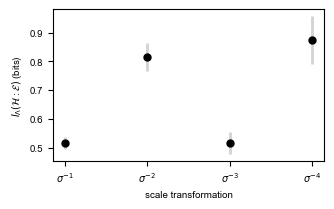

In [735]:
means = [np.mean(np.array(vec)/np.log(2)) for vec in all_estimates.values()]
stds = [np.std(np.array(vec)/np.log(2)) for vec in all_estimates.values()]
scales = [1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(8.9*cm, 5*cm))

#ax.plot(scales, all_estimates.values(), 'k.')
ax.errorbar(scales, means, yerr=stds, fmt='k.', ecolor='lightgray', elinewidth=2, markersize=10)
ax.set_xticks(scales)
ax.set_xticklabels([r'$\sigma^{-%i}$' %scale for scale in scales])
ax.set_ylabel(r'$I_\Lambda\left(\mathcal{H}:\mathcal{E}\right)$ (bits)')
ax.set_xlabel(r'scale transformation')

plt.savefig('3v_mi_scales.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

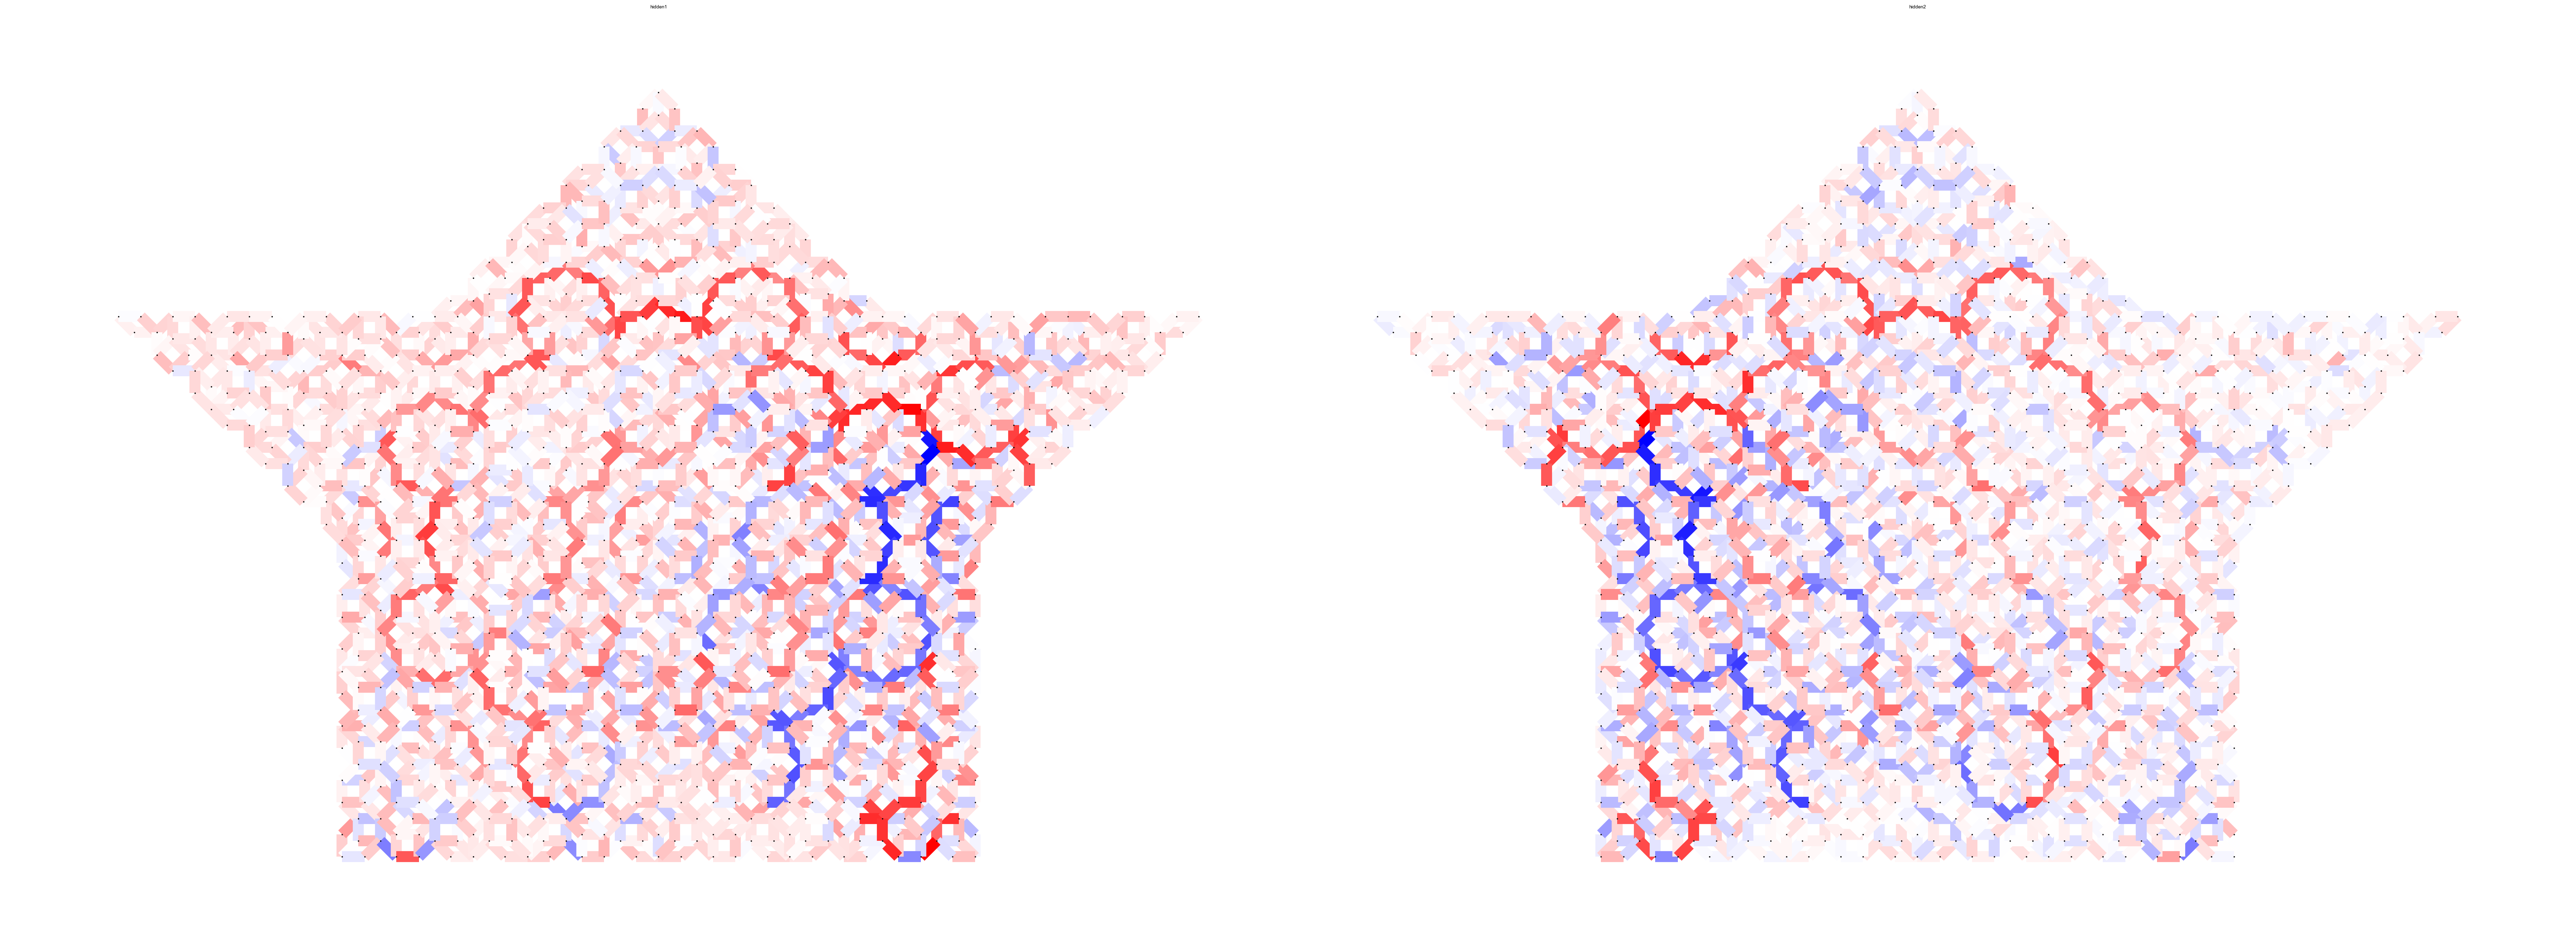

In [723]:
# The nice built-in visualization functions expect this "dictionary of cases" format of inputs.
%matplotlib inline

scale_fac = 2*int(np.ceil(np.cbrt(len(cGV_edges[EV_params['case_no']]))))
if len(nonlinearCG_layers) > 1:
    if nonlinearCG_layers[0] > 20:
        skip = nonlinearCG_layers[0] // 20
        num_cols = 20
    else:
        skip = 1
        num_cols = nonlinearCG_layers[0]

    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1][0][:, ::skip], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=num_cols, figsize=(num_cols*scale_fac, 3*scale_fac), title="hidden", width=16,)
else:
    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=hidden_dim, figsize=(hidden_dim*scale_fac, 3*scale_fac), title="hidden", width=16)


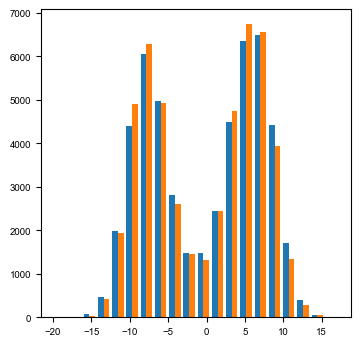

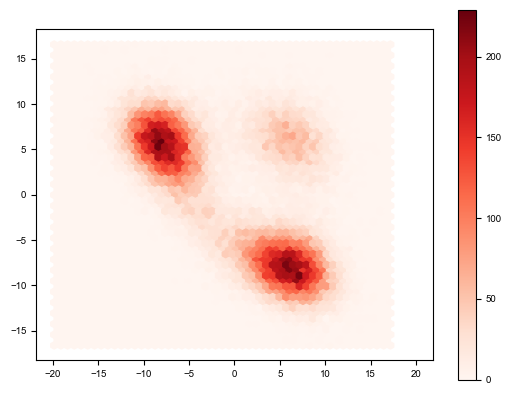

In [724]:
test_prods = dot_prod_V(Vs_dict[case_no][:, :, 0], None, filters[-1])

fig = plt.figure(figsize=(4, 4))
plt.hist(test_prods[:], bins=20)

hexbin_visualize(test_prods[:, 0], test_prods[:, 1], gridsize=50)


In [725]:
%matplotlib inline

#case_no = case_no

#test_pr = net(Vs_dict[case_no]).numpy()

test_pr = np.heaviside(dot_prod_V(Vs_dict[case_no][:, :, 0],
                                  None, filters[-1]), 0)


fig = plt.figure(figsize=(5, 5))


if hidden_dim > 2:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(test_pr[:, 0], test_pr[:, 1], test_pr[:, 2], s=0.01)
    #ax.set_zlim(-1,1)
    ax.view_init(10, 50)
if hidden_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(test_pr[:, 0], test_pr[:, 1], s=0.01)


In [726]:
counts, labels, all_labels, hist = embedding_statistics(test_pr, CG_params)

vertex_type_corr = '3'

if hidden_dim == 4:
    fig, ax = plt.subplots(1, figsize=(5.5*cm, 2*cm))
elif hidden_dim == 2:
    fig, ax = plt.subplots(1, figsize=(3*cm, 2.3*cm))

if vertex_type_corr == '8':
    colour = 'b'
elif vertex_type_corr == '3':
    colour = 'r'

freqs = {key: counts[key]/len(test_pr) for key in counts}

ymax = 1.1 * max(freqs.values())

ax.axhline(1/8, color='gray', linestyle='-', label=r'$1/8}$', alpha=0.5)
ax.bar(all_labels, freqs.values(), color=colour,)

ax.set_ylabel(r'${\rm frequency}$')
ax.set_xlabel(r'$\mathcal{H}$')
ax.tick_params(axis='x', labelrotation=45)

ax2 = ax.twinx()
ax2.set_yticks([1/8])
ax2.set_yticklabels([r'$\frac{1}{8}$'])
ax2.set_ylim([0, ymax])
ax.set_ylim([0, ymax])
ax.set_xlim([-.5, 2**hidden_dim - .5])

#plt.savefig(scale+'_'+vertex_type+'v_dist.pdf', dpi=500, bbox_inches='tight')


(-0.5, 3.5)

{(0, 0): array([   14,    21,    32, ..., 49979, 49984, 49986]),
 (0, 1): array([    2,     7,     8, ..., 49994, 49996, 49999]),
 (1, 0): array([    0,     3,     4, ..., 49992, 49997, 49998]),
 (1,
  1): array([    1,     9,   153,   185,   210,   239,   310,   377,   416,
          537,   611,   658,   678,   685,   757,   900,   914,   915,
         1012,  1056,  1067,  1079,  1104,  1204,  1226,  1320,  1399,
         1529,  1547,  1630,  1632,  1705,  1768,  1811,  1924,  1944,
         2289,  2297,  2335,  2337,  2390,  2398,  2466,  2513,  2541,
         2658,  2693,  2747,  2846,  2870,  2971,  2985,  3049,  3068,
         3092,  3125,  3161,  3210,  3222,  3240,  3515,  3560,  3610,
         3623,  3650,  3717,  3801,  3832,  3882,  3895,  3939,  3964,
         4022,  4168,  4270,  4355,  4424,  4429,  4522,  4567,  4592,
         4594,  4600,  4619,  4657,  4668,  4687,  4710,  4742,  4802,
         4804,  4816,  4843,  4854,  4901,  4905,  4928,  4991,  5011,
         5052,

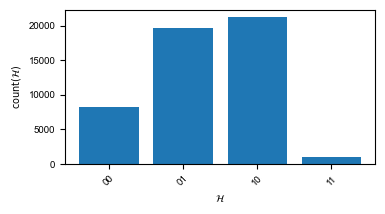

In [299]:
#%matplotlib notebook

fig, ax = plt.subplots(1, figsize=(4, 2))

ax.bar(all_labels, counts.values())
ax.set_ylabel(r'${\rm count}(\mathcal{H})$')
ax.set_xlabel(r'$\mathcal{H}$')

ax.tick_params(axis='x', labelrotation=45)


CGfilter_corrr = dict()

# returns the sample indices with given CG state
for str_symbol in freqs.keys():
    label = tuple([int(char) for char in str_symbol])
    if CG_params['use_logits']:
        CGfilter_corrr[label] = np.where(
            np.all(np.heaviside(test_pr-0.5, 0) == list(label), axis=1))[0]
    else:
        CGfilter_corrr[label] = np.where(
            np.all(np.sign(test_pr) == list(label), axis=1))[0]

CGfilter_corrr


In [251]:
Vs_dict = load_Vs(samples, [53], 389, sample_data_dir)


[10705] 10705
Case: 53, shape Vs:  (50000, 488, 1)


In [253]:
%matplotlib inline

#case_no = case_no

#test_pr = net(Vs_dict[case_no]).numpy()

test_pr = np.heaviside(dot_prod_V(Vs_dict[53][:, :, 0],
                                  None, purified_filters), 0)


fig = plt.figure(figsize=(5, 5))


if hidden_dim > 2:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(test_pr[:, 0], test_pr[:, 1], test_pr[:, 2], s=0.01)
    #ax.set_zlim(-1,1)
    ax.view_init(10, 50)
if hidden_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(test_pr[:, 0], test_pr[:, 1], s=0.01)


In [261]:
Hs_filtered


array([[0., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 1., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 1., 1.]], dtype=float32)

In [267]:
state = 3

symbol = list(CGfilter_corrr.keys())[state]
str_symbol = "".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))


print('Filtering current representation for symbol',
      symbol,
      'from previous run.')


Hs_filtered = test_pr[CGfilter_corrr[symbol]]
#print(row_counter(Hs_filtered))

counts_filtered, labels_filtered, all_labels, _ = embedding_statistics(Hs_filtered, CG_params, hidden_dim=4)


freqs_filtered = {key: counts_filtered[key] /
                  len(Hs_filtered) for key in counts_filtered}

fig, ax = plt.subplots(1, figsize=(6, 3))

ax.bar(all_labels, freqs_filtered.values())
ax.set_ylabel(r'$P(\mathcal{H}|h_3='+str_symbol+')$')
ax.set_xlabel('$\mathcal{H}$')

ax.tick_params(axis='x', labelrotation=45)


Filtering current representation for symbol (1, 1) from previous run.


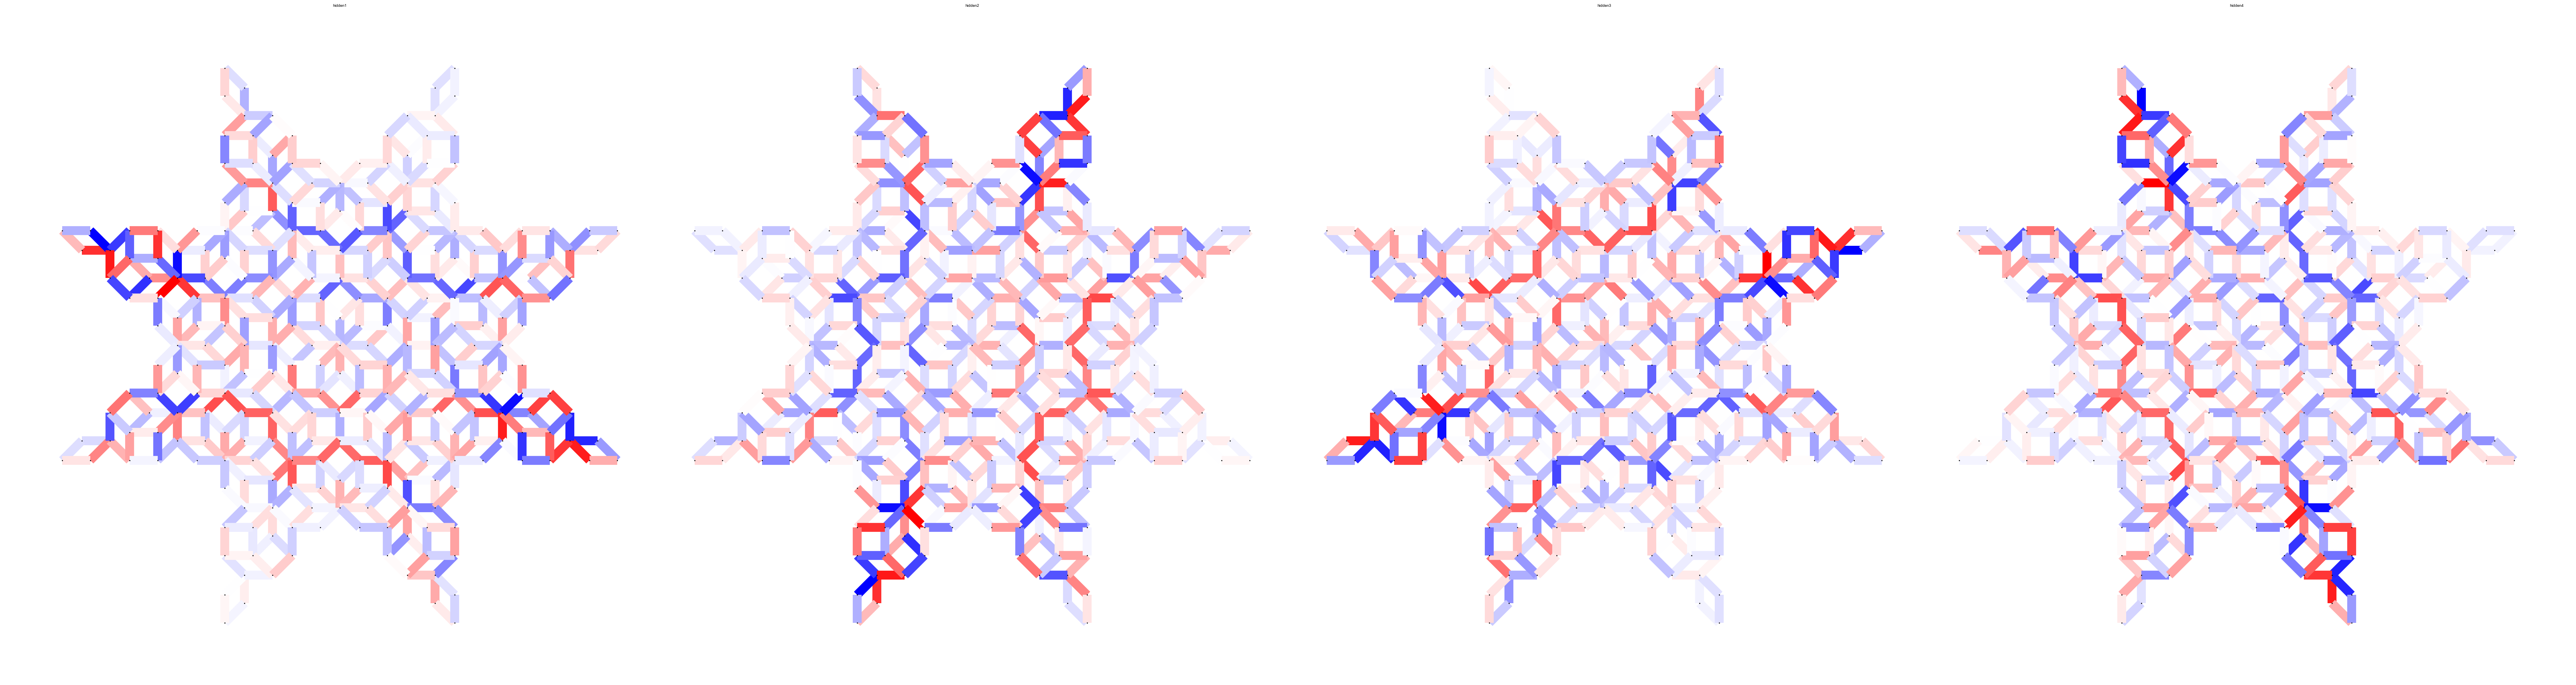

In [86]:
angle = np.pi/2

fid = 2

f = []
for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])


for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], 5*np.pi/4+i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])

purified_filters = np.array(f).transpose()

small_V_visualize(cGV_edges[EV_params['case_no']], purified_filters, edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=4, figsize=(hidden_dim*scale_fac, 3*scale_fac),
                  title="hidden", width=16)
